## Import dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline

## Define model Parameters

In [7]:
IMAGE_SIZE= 512
BATCH_SIZE= 16
CHANNELS=3

## Acces DataSet 
we are using "keras.preprocessing" method to acces our structured Data folder
- data structure ullistration: 

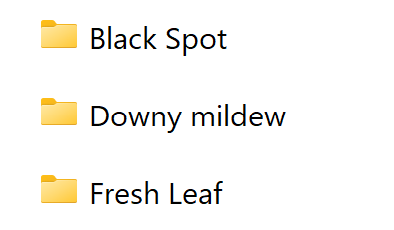


In [8]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4342 files belonging to 3 classes.


In [9]:
class_names=dataset.class_names
class_names

['Black Spot', 'Downy mildew', 'Fresh Leaf']

In [10]:
len(dataset)

272

## Display DataSet Examples

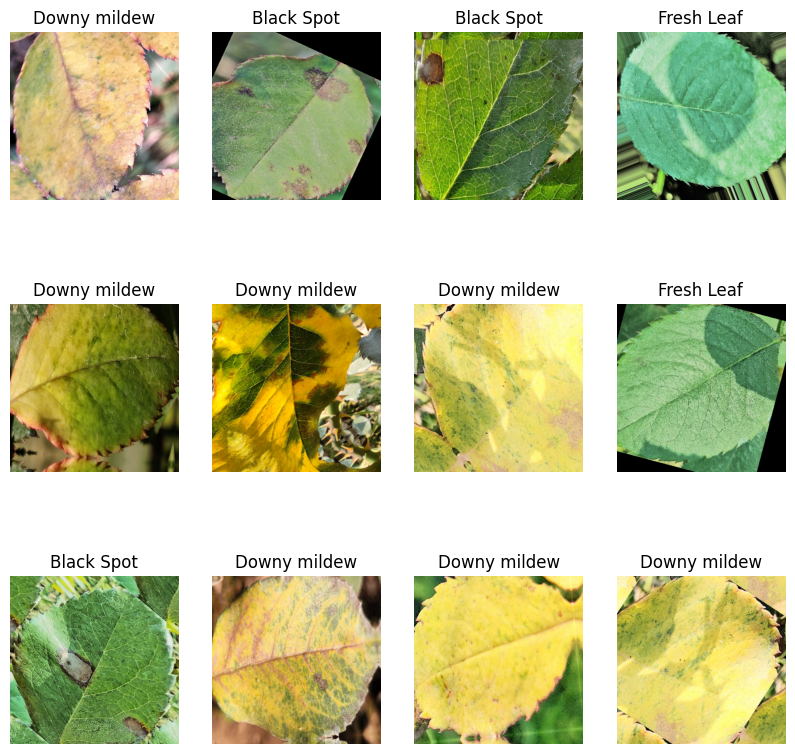

In [12]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

## Train-Validation-Test Split

In machine learning, it's crucial to split your dataset into three subsets: training set, validation set, and test set. This allows you to train your model, tune hyperparameters, and evaluate its performance effectively.

<center>

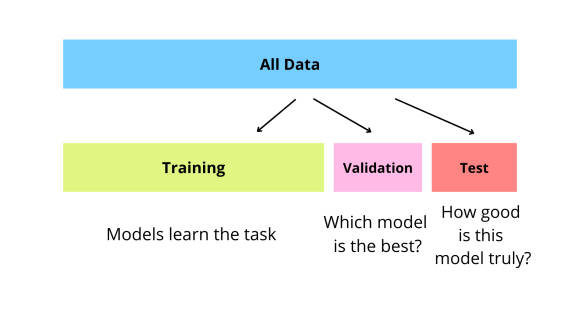

</center>

### Training Set
- **Purpose**: The training set is used to train the model's parameters. 
- **Size**: Typically, 80% of the original dataset is allocated for training.
- **Usage**: The model learns from this data to make predictions.

### Validation Set
- **Purpose**: The validation set is used to fine-tune model hyperparameters and to provide an unbiased evaluation of a model fit on the training data.
- **Size**: 10% of the original dataset is usually allocated for validation.
- **Usage**: After training the model, it's evaluated on the validation set to adjust hyperparameters and optimize model performance.

### Test Set
- **Purpose**: The test set is used to evaluate the final model's performance and estimate how it will perform on unseen data.
- **Size**: Also, 10% of the original dataset is allocated for testing.
- **Usage**: The model is evaluated on the test set only once, after all training and validation stages are completed, to provide an unbiased evaluation of its performance on new, unseen data.

### Splitting Process
1. **Randomization**: The dataset is shuffled randomly to avoid any underlying order or bias in the data.
2. **Splitting**: The randomized dataset is divided into training, validation, and test sets according to the specified percentages.

### Importance
- **Prevents Overfitting**: By using a validation set, we can detect and prevent overfitting by fine-tuning model parameters.
- **Unbiased Evaluation**: The test set provides an unbiased evaluation of the model's performance on unseen data, giving a realistic estimation of its generalization capabilities.
- **Hyperparameter Tuning**: The validation set helps in optimizing hyperparameters, ensuring the model's robustness across different datasets.

The train-validation-test split is a fundamental practice in machine learning to ensure reliable model training, tuning, and evaluation.



## Defining Function: `get_dataset_partitions`

This function is used to partition a given dataset into training, validation, and test sets according to specified ratios.

### Parameters:
- `ds` (tf.data.Dataset): The dataset to be partitioned.
- `train` (float, optional): The ratio of the dataset allocated for the training set. Defaults to 0.8.
- `val` (float, optional): The ratio of the dataset allocated for the validation set. Defaults to 0.1.
- `test` (float, optional): The ratio of the dataset allocated for the test set. Defaults to 0.1.
- `shuffle` (bool, optional): Whether to shuffle the dataset before partitioning. Defaults to True.
- `shuffle_size` (int, optional): The buffer size used for shuffling the dataset. Defaults to 10000.

### Returns:
- `train_ds` (tf.data.Dataset): The training set partition.
- `val_ds` (tf.data.Dataset): The validation set partition.
- `test_ds` (tf.data.Dataset): The test set partition.

### Description:
This function takes a TensorFlow dataset `ds` and partitions it into three subsets: training, validation, and test sets. The dataset can be shuffled before partitioning using the `shuffle` parameter. The sizes of the partitions are determined by the specified ratios (`train`, `val`, `test`). The function returns three datasets: `train_ds`, `val_ds`, and `test_ds`.



In [13]:
def get_dataset_partitions(ds,train=0.8,val=0.1,test=0.1,shuffle=True,shuffle_size=10000):
    ds_size= len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=10)
    
    train_size= int(train*ds_size)
    val_size=int(val*ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [14]:
train_ds,val_ds,test_ds = get_dataset_partitions(dataset)

In [15]:
len(train_ds), len(val_ds), len(test_ds)

(217, 27, 28)

## Applying cache and prefetch

### Function: `prefetch_cache`

This function is used to optimize the performance of a TensorFlow dataset by caching, shuffling, and prefetching it.

### Parameters:
- `ds` (tf.data.Dataset): The dataset to be optimized.
- `shuffle` (bool, optional): Whether to shuffle the dataset. Defaults to True.
- `shuffle_size` (int, optional): The buffer size used for shuffling the dataset. Defaults to 1000.
- `prefetch` (bool, optional): Whether to prefetch elements of the dataset. Defaults to True.
- `buffer` (int, optional): The number of elements to prefetch. Defaults to `tf.data.AUTOTUNE`.

### Returns:
- `ds` (tf.data.Dataset): The optimized dataset.

### Description:
This function takes a TensorFlow dataset `ds` and applies caching, shuffling, and prefetching operations to optimize its performance. First, it caches the dataset to reduce the time taken to access the data. Then, if specified, it shuffles the dataset to improve randomness during training. Finally, it prefetches elements of the dataset to overlap the preprocessing and model execution, reducing the time wasted waiting for data.



In [16]:
def prefetch_cache(ds,shuffle=True,shuffle_size=1000,prefetch=True,buffer=tf.data.AUTOTUNE):
    
    ds =ds.cache()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size)
        
    if prefetch:
        ds = ds.prefetch(buffer)
        
    return ds

In [17]:
prefetch_cache(train_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [18]:
prefetch_cache(test_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
prefetch_cache(val_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Preprocessing
We will build the model now, but we first need to make sure that **all pictures are scaled** and have the same size

In [20]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

## Data Augmentation Sequential Model (Optional)

This Sequential model is used for data augmentation, a technique commonly employed in training deep learning models to improve generalization and robustness by artificially increasing the diversity of the training dataset.



In [21]:
# data_augmentation=tf.keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     layers.experimental.preprocessing.RandomTranslation(0,0.3), 
# ])

# data_augmentation1=tf.keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     layers.experimental.preprocessing.RandomTranslation(0,0.3),
#     layers.experimental.preprocessing.RandomRotation(0.1),
    
# ])


# data_augmentation2=tf.keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     layers.experimental.preprocessing.RandomTranslation(0,0.3),
#     layers.experimental.preprocessing.RandomRotation(0.1),
#     layers.experimental.preprocessing.RandomContrast(0.1),
    
# ])

## Applying Data augmentation to train dataset (Optional)

In [22]:
# # First set of augmented dataset
# train_ds_augmented_1 = train_ds.map(
#     lambda x, y: (data_augmentation(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

# # Second set of augmented dataset
# train_ds_augmented_2 = train_ds.map(
#     lambda x, y: (data_augmentation1(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

# # Third set of augmented dataset
# train_ds_augmented_3 = train_ds.map(
#     lambda x, y: (data_augmentation2(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
# Combine the three augmented datasets into one
# combined_train_ds = train_ds.concatenate(train_ds_augmented_1).concatenate(train_ds_augmented_2).concatenate(train_ds_augmented_3)


## Saving Augemanted Images to Disk (Optional)

This code snippet demonstrates how to save images from a TensorFlow dataset to disk.

### Prerequisites:
- `os`: Standard library for interacting with the operating system.
- `tensorflow`: TensorFlow library for machine learning tasks.

### Parameters:
- `output_folder` (str): The directory where the images will be saved.
- `combined_train_ds` (tf.data.Dataset): The combined dataset containing images and their corresponding labels.

### Description:
The code iterates over each element in the combined dataset, which consists of images and their corresponding labels. For each image in the batch, it converts the image tensor to a NumPy array, scales it to the [0, 255] range, and saves it as a JPEG file. The file name is defined based on the image's label and an incremental index. Images are saved to subdirectories within the `output_folder` based on their labels.


In [ ]:
# import os
# import tensorflow as tf

# # Define the directory where you want to save the results
# output_folder = "new_dataset"

# # Create the output folder if it doesn't exist
# os.makedirs(output_folder, exist_ok=True)
# k={class_names[0]:0,class_names[1]:0,class_names[2]:0,}
# # Iterate over each element in the combined dataset
# for i, (images, labels_index) in enumerate(combined_train_ds):
#     # Iterate over each image in the batch
#     print(labels_index)
#     for j in range(images.shape[0]):
#         image = images[j]
#         label=class_names[labels_index[j]]
#         k[label]=k[label]+1
#         # Convert the image tensor to numpy array
#         image_np = (image.numpy()).astype('uint8')  # Scale to [0, 255] and convert to uint8

#         # Define the file name based on the index (or any other naming convention you prefer)
#         file_name = f"{label}_{ k[label]}.jpg"
#         os.makedirs(os.path.join(output_folder, label ), exist_ok=True)

#         # Define the path where the image will be saved
#         file_path = os.path.join(output_folder, label ,file_name)

#         # Save the image to the file path
#         with open(file_path, 'wb') as f:
#             f.write(tf.image.encode_jpeg(image_np).numpy())

## Model Definition: 
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.


### Model Architecture:
- **Input Shape**: (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
- **Number of Classes**: 3

The model consists of several convolutional layers followed by max-pooling layers, a flattening layer, and fully connected (dense) layers for classification.

1. **Input Preprocessing**:
   - `resize_and_rescale`: Preprocessing layer for resizing and rescaling the input images.

2. **Convolutional Layers**:
   - `Conv2D`: Convolutional layers with ReLU activation.
     - First Conv2D layer with 32 filters and kernel size of (3, 3).
     - Subsequent Conv2D layers with increasing number of filters and kernel size of (3, 3).
  
3. **Max Pooling Layers**:
   - `MaxPooling2D`: Max pooling layers with pool size of (2, 2) to downsample feature maps.

4. **Flattening Layer**:
   - `Flatten`: Flatten layer to convert 2D feature maps into a 1D vector for input to the dense layers.

5. **Fully Connected Layers**:
   - `Dense`: Fully connected dense layers with ReLU activation.
     - One hidden dense layer with 64 units.

6. **Output Layer**:
   - `Dense`: Output layer with softmax activation for classification into `n_classes` (3) categories.



In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 512, 512, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 510, 510, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (16, 255, 255, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 253, 253, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 126, 126, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (16, 124, 124, 64)       

## Compiling the model

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## Training 

In [76]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
217/217 [==============================] - 391s 2s/step - loss: 0.5469 - accuracy: 0.6910 - val_loss: 0.5396 - val_accuracy: 0.7251
Epoch 2/20
217/217 [==============================] - 389s 2s/step - loss: 0.5247 - accuracy: 0.7267 - val_loss: 0.5705 - val_accuracy: 0.7176
Epoch 3/20
217/217 [==============================] - 386s 2s/step - loss: 0.4454 - accuracy: 0.7831 - val_loss: 0.5090 - val_accuracy: 0.7245
Epoch 4/20
217/217 [==============================] - 385s 2s/step - loss: 0.4193 - accuracy: 0.7998 - val_loss: 0.3944 - val_accuracy: 0.8542
Epoch 5/20
217/217 [==============================] - 382s 2s/step - loss: 0.4050 - accuracy: 0.8111 - val_loss: 0.3570 - val_accuracy: 0.8333
Epoch 6/20
217/217 [==============================] - 384s 2s/step - loss: 0.3626 - accuracy: 0.8350 - val_loss: 0.2981 - val_accuracy: 0.8588
Epoch 7/20
217/217 [==============================] - 386s 2s/step - loss: 0.3462 - accuracy: 0.8481 - val_loss: 0.3262 - val_accuracy: 0.8565

In [26]:
#Model evaluation 
scores = model.evaluate(test_ds)

28/28 [==============================] - 19s 325ms/step - loss: 1.0985 - accuracy: 0.3348


## Function: `plot_training_history`

This function is used to visualize the training and validation accuracy and loss values over epochs.

### Parameters:
- `history` (tf.keras.callbacks.History): The training history obtained from model training.

### Description:
This function plots the training and validation accuracy as well as the training and validation loss over epochs. It helps in visualizing the training progress and identifying any potential overfitting or underfitting issues.


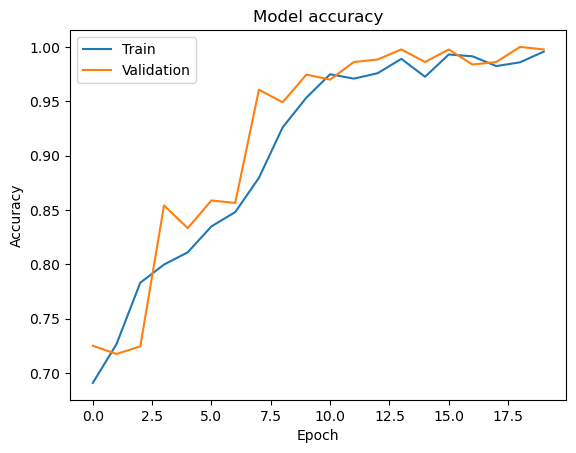

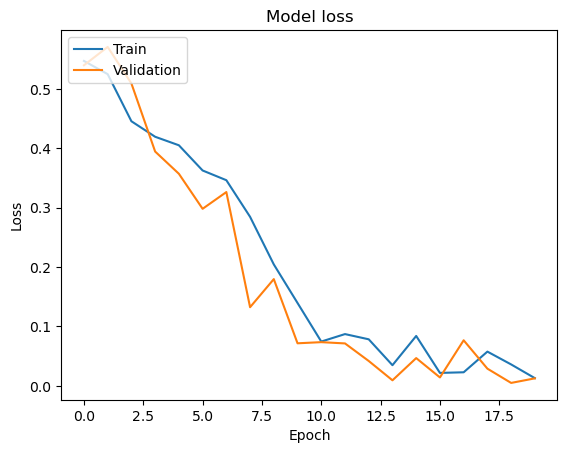

In [79]:
# Plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history["val_accuracy"])

    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history["val_loss"])

    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Call the function to plot the training history
plot_training_history(history)

# Run prediction on simple image

first image to predict
actual label: Fresh Leaf
1/1 [==============================] - 1s 1s/step
predicted label: Fresh Leaf


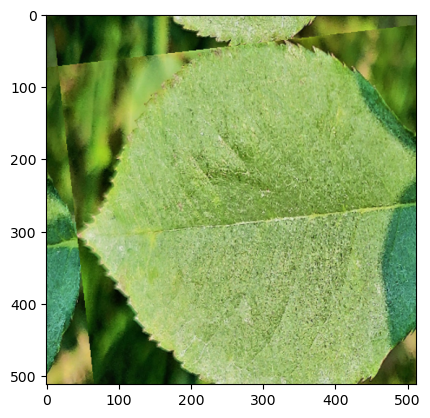

In [81]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Writing a function for inference

In [83]:
from PIL import Image
def predict(model, path):
    img=Image.open(path)
    plt.imshow(img)

    img_array = tf.keras.preprocessing.image.img_to_array(img)
    #plt.imshow(img_array.astype("uint8"))
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [96]:
def predict_all(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Now we run inference on few sample images

1/1 [==============================] - 0s 109ms/step


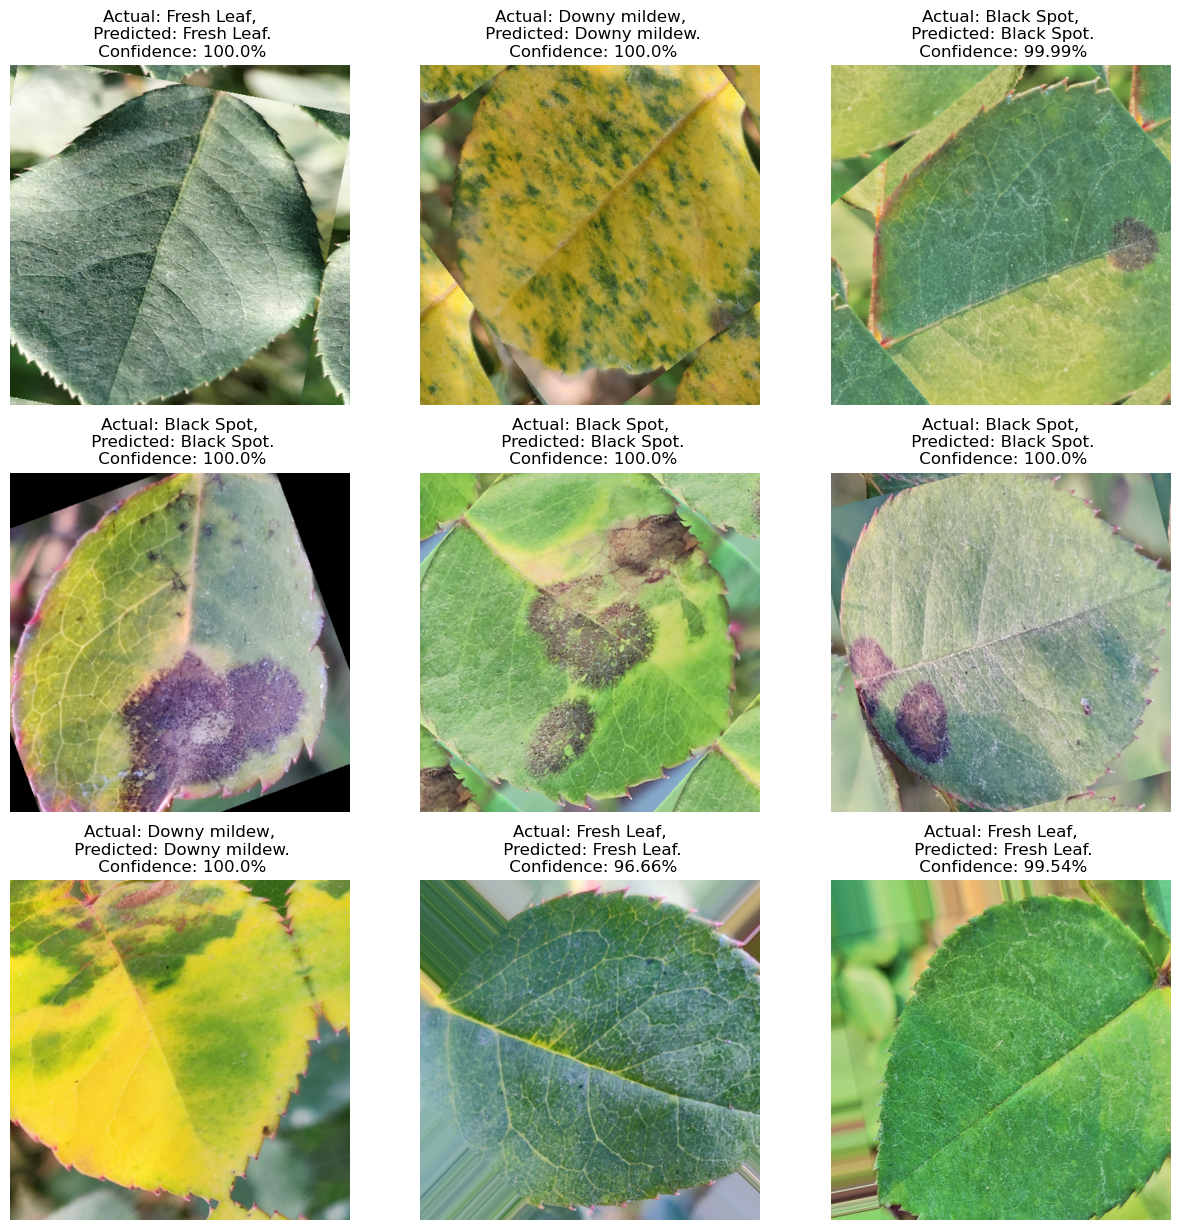

In [97]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict_all(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

1/1 [==============================] - 1s 509ms/step


('Downy mildew', 80.68)

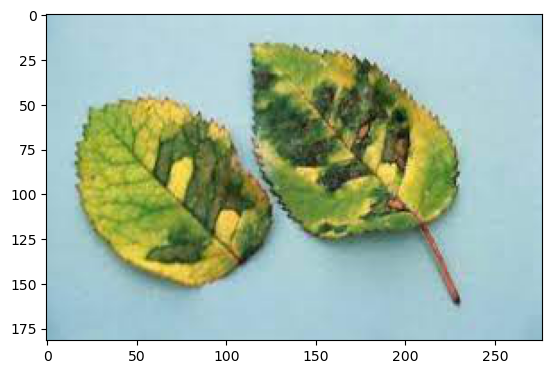

In [89]:
predict(model,"test/DM.jpeg")

1/1 [==============================] - 0s 108ms/step


('Downy mildew', 100.0)

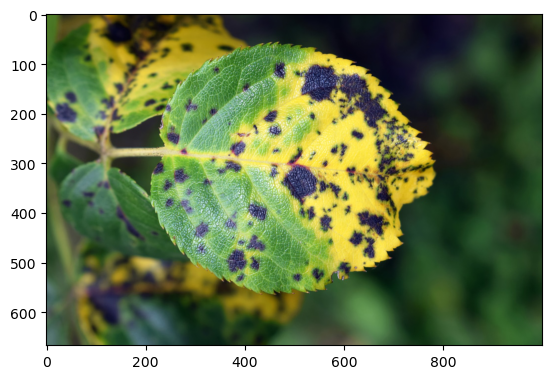

In [91]:
predict(model,"test/DM2.jpg")

1/1 [==============================] - 0s 110ms/step


('Black Spot', 89.68)

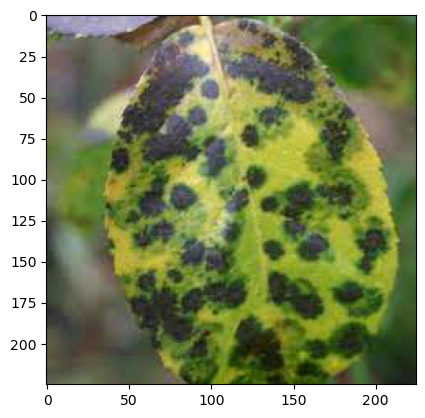

In [92]:
predict(model,"test/BS.jpeg")

1/1 [==============================] - 0s 125ms/step


('Black Spot', 100.0)

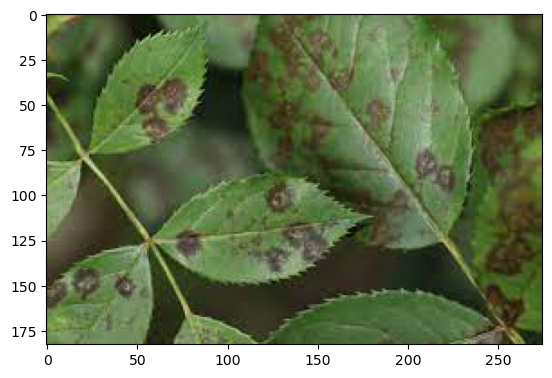

In [94]:
predict(model,"test/BS2.jpeg")

## Saving the model
Here we append the model to the list of models as a new version

In [ ]:
model.save("Saved_model_version1")

INFO:tensorflow:Assets written to: augmented_data\assets


INFO:tensorflow:Assets written to: augmented_data\assets
